# Custom image detection with fast.ai

## Overview

We want to make a model that will work for our specific, unique problem: detecting whether helicopter flight maps show a copter was "circling" or "not circling."

### Transfer learning with a pre-trained model

One way to solve this problem would be to teach, or _train_ a _model_ – really a complex mathematical formula – to match images to labels. For good results, we'd need to use millions of images. It's doable ... but there's another option.

We'll use a _pre-trained model_ – one already trained by some other, kind people, who built it using millions of images and then shared it on the internet for others to use. We'll use the "smarts" of that model, which has learned to detect patterns in images generally, to solve our particular problem. We do that by _additionally_ training the original model on our own data set – the helicopter flight maps.

### ResNet

[ResNet](https://arxiv.org/abs/1512.03385) is a pre-trained model that was trained on the images and labels of 1.2 million pictures in a database called [ImageNet](http://www.image-net.org/about-overview).

It is a _neural network_ that has "learned" how to "look" at those images and make a guess of what the image contains from a list of 1,000 possible labels.

But we want just two labels: "circling" and "not circling"

So we strip off the last calculations of the ResNet model ... the part that guesses between 1,000 possibilites ... and train it with our images to guess just two possibilities.

### fast.ai

[Fast.ai](https://fast.ai) is the software we'll use to take the complex mathematical formula described by the ResNet model, do transfer-learning on the original model with our custom maps, and apply the final model to new images. 

## The Plan

We're going to train a model to recognize helicopter flight maps as either "circling" or "not circling" using a relatively small number of training images (just shy of 300 total).

- We'll start with a moodel pre-trained on 1.2 million image.
- Next we'll use "transfer learning" with fast.ai to further train that model with our helicopter maps

## Credits

This notebook started as a copy of the lesson 1 notebook in [Practical Deep Learning for Coders](https://course.fast.ai/), taught online by Jeremy Howard. I **highly** recommend this free online course. 

For more of my process here, see [this blog post](https://qz.ai/spotting-circling-helicopters/).

-- John Keefe, [Quartz](https://qz.com), October 2019

## Setup

### For those using Google Colaboratory ...

Be aware that Google Colab instances are ephemeral -- they vanish *Poof* when you close them, or after a period of sitting idle (currently 90 minutes), or if you use one for more than 12 hours.

If you're using Google Colaboratory, be sure to set your runtime to "GPU" which speeds up your notebook for machine learning:

![change runtime](https://qz-aistudio-public.s3.amazonaws.com/workshops/notebook_images/change_runtime_2.jpg)
![pick gpu](https://qz-aistudio-public.s3.amazonaws.com/workshops/notebook_images/pick_gpu_2.jpg)

Then run this cell:

In [1]:
## ALL GOOGLE COLAB USERS RUN THIS CELL

## This runs a script that installs fast.ai
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


### For those _not_ using Google Colaboratory ...

This section is just for people who decide to use one of the notebooks on a system other than Google Colaboartory. 

Those people should run the cell below.

In [0]:
## NON-COLABORATORY USERS SHOULD RUN THIS CELL
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Everybody do this ...

Everyone needs to run the next cell, which initializes the Python libraries we'll use in this notebook.

In [2]:
## AND *EVERYBODY* SHOULD RUN THIS CELL
import warnings
warnings.filterwarnings('ignore')
from fastai.vision import *
from fastai.metrics import error_rate
import fastai
print(f'fastai: {fastai.__version__}')
print(f'cuda: {torch.cuda.is_available()}')

fastai: 1.0.59
cuda: True


## The Data

We're going to download some data for this notebook, which is mainly just a folder containing some pictures I took.

Probably the trickiest part of machine learning image problems involve pairing the images with their proper labels. There are many ways to do this. Sometimes the labels are in the file names. Sometimes they're in a list. Ours are in two separate folders, or directories:

- One folder contains circling images
- One folder contains not-circling images

I made these folders by sorting through about 300 maps of helicopter flight paths. Took me about 15 minutes.

 Mount Drive to working folder

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%cd /content/drive/'My Drive'/Colab_Notebooks/ml_journalists

In [9]:
# Run this cell to download the data we'll use for this exercise
!wget -N https://qz-aistudio-public.s3.amazonaws.com/workshops/chopper_data.zip --quiet
!unzip -q chopper_data.zip
print('Done!')

Done!


Let's look at what we have.

In [10]:
%ls data/choppers

circling/  not_circling/


In [0]:
data_path ='./data/choppers'

In [0]:
my_transforms = None  # note: We'll talk more about transforms later

data = (ImageList.from_folder(data_path) # Where to find the data? -> in path and its subfolders
        .split_by_rand_pct()        # How to split in train/valid? -> do it *randomly* (Not by folder)
        .label_from_folder()        # How to label? -> get from the folder name
        .transform(my_transforms, size=600)  # Data augmentation? -> use tfms with a size of 600, because they all are
        .databunch(bs=16))          # Size of simultaneous batches -> 16 (higher is faster & uses more memory)

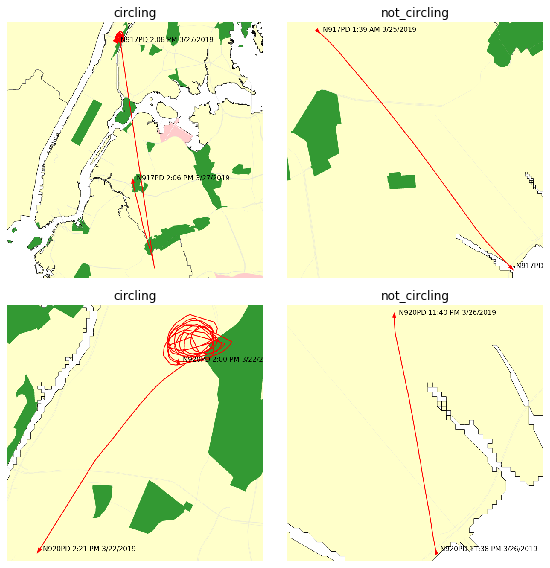

In [15]:
data.show_batch(rows=2)

In [16]:
print(data.classes)

['circling', 'not_circling']


## The Code

Now we will start training our model - which is a convolutional neural network(!) For a deep dive on that, definitely check out the fast.ai courses.

But for now, you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories: `circling` and `not_circling`

### Transfer learning with resnet34

Training a computer-vision mode from scratch to solve our problem would take thousands of images. Maybe more. Instead we take advantage of an existing model that was trained to detect objects -- from planes, to cars, to dogs, to birds -- by processing millions of images. This model is called "resnet34."

With fast.ai we can infuse this model with our images (and their labels). This takes advantage of all of resnet34's "knowledge" of image-detection and tacks on our particular problem. This technique is called "transfer learning." 

First we load our `data` and `model.resnet34` together into a training model known as a "learner."

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

We will train for 8 epochs (8 cycles through all our data).

In [0]:
learn.fit_one_cycle(8)

**Important note:** Every time you use `learn.fit_one_cicle` it does _additional_ training on your model. If your results get all screwy and you want to start over, the best thing to do is reset the "runtime" (or "kernel" in Jupyter notebooks) for this notebook. 

![reset runtime](https://qz-aistudio-public.s3.amazonaws.com/workshops/notebook_images/reset_runtimes.png)

This clears out everything (basically like a restart) and you have to play all the cells again to start fresh. 

### How are we doing? 

So far, we have a pretty good error rate.

Let's look to see where the model was most confused, and whether what the model predicted was reasonable or not. 

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

interp.plot_top_losses(9)

You can add "heatmap=True" to the `interp` line above, like this:

```
interp.plot_top_losses(9, heatmap=True)
```

The "hot" areas of the images are the parts the model is using to make its decision.

In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see how the mistakes are being made. 

In [0]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

## Let's try a fresh image

Now I grab a single, brand new image.

In [0]:
img = open_image('data/not_yet_seen.png')

In [0]:
img

Then we _predict_ what class this image falls into. 

In [0]:
pred_class, pred_idx, outputs = learn.predict(img)

In [0]:
pred_class

## Saving your work

At present, your Google Colaboratory Notebook disappears when you close it — along with all of your data and the values of the variables we set. That includes the model, which is called `learn`.

### Saving *notebooks* to Google Drive

You may have seen this alert ...

![change runtime](https://qz-aistudio-public.s3.amazonaws.com/workshops/notebook_images/save_alert.png)

... or even thought to save your notebook to Google Drive using the menu bar. 

![pick gpu](https://qz-aistudio-public.s3.amazonaws.com/workshops/notebook_images/save_dropdown.png)

**_IMPORTANT NOTE: Saving your notebook this way does not save your data or your models ... it saves only the text of the notebook as you see it._**

You are welcome to do this, but also note that your saved version won't include any future changes, improvements, or bug-fixes I make in the notebook. For that, be sure to start anew each time from Github.

### Saving *models* to Google Drive

If you've got a really sweet predictor and want to save your model, you can! 

You need to connect your Google Colaboratory notebook to your Google Drive, where we'll make a folder called "ai-workshop." You can do that by running the following cell and following the prompts:

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'ai-workshop/chopper_models/'
save_path = Path(base_dir)
save_path.mkdir(parents=True, exist_ok=True)

The next line will save everything we need for predictions to a file to your Google Drive in the `ai-workshops` folder.

In [0]:
learn.export(save_path/"export.pkl")

### Using your model elsewhere (advanced)

Making _predictions_ – that is, guessing the class or contents of an image – is something for which you don't need a powerful computer. You don't need a GPU, or graphics processing unit. A regular computer's CPU (central processing unit) will do just fine.

If you know how ([or take a moment to learn how](https://jupyter.readthedocs.io/en/latest/content-quickstart.html)) to run this notebook as a "jupyter notebook," you can run this code right off your own laptop. This can be especially useful if you have all your data on your computer and it's too much to upload to Google Colaboratory.

Here's how to tell fast.ai to use the CPU instead of GPU.

In [0]:
defaults.device = torch.device('cpu')  # for the gpu it would be 'cuda'

To use your model, you'll need to load it into the code.

Here's how to load it from your Google Drive:

In [0]:
# load the model from the 'export.pkl' file on your Google Drive
learn = load_learner(save_path)  

Or you can download the `.pkl` file to your own computer and load it from there.

In [0]:
# load the model from your own computer
learn = load_learner('path/to/your/model/export.pkl')  

In [0]:
# Then, load in an image and predict away!

img = open_image('path/to/an/image/file')

pred_class,pred_idx,outputs = learn.predict(img)

In [0]:
pred_class

To process data in real time – say, as tweets are tweeted or whenever a helicopter is flying – you can also host your code on a service like [Render](https://render.com). The guide for production deployment to Render is at https://course.fast.ai/deployment_render.html. Also check out [Render's fast.ai forum thread](https://forums.fast.ai/t/deployment-platform-render/33953) for questions and support.